# Analysing HMLR domestic property sale £ prices using the HMLR 'Price Paid' dataset

The method identifies change between 2012 - 2022 for individual properties in England and Wales including metrics for urban-rural classification, regional patterns, and property type, checking counts for statistical significance.
The method uses Python 3.

The HM Land Register 'Price Paid' data provides complete and accurate sales £ transaction data for properties at the property level, making it useful for small-area geographically detailed and precise analysis.

The data can be downloaded as a flat file from https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads ('the complete Price Paid Transaction Data as a CSV file') which shows some discovery metadata. Additional metadata can be found at https://landregistry.data.gov.uk/app/root/doc/ppd#:~:text=The%20price%20paid%20dataset%20is%20available%20in%20several,to%20use%20under%20the%20terms%20of%20the%20OGL.  Data is open government data under OGL licence.

A combination of spatial and non-spatial analysis libraries are used for the data engineering, and matplotlib together with geoplot to show some basic trends.

In [ ]:
import pandas
import geopandas
import matplotlib.pyplot as plt
import folium
import branca.colormap as cm

Firstly, import the 'price paid' data for both 2012 and 2022 with relevant headers and specified datatypes from the flat files into a dataframe. An API method could be considered: for context we are interested in querying the entire dataset initially.

In [ ]:
colnames=['pricepaid', 'date','postcode', 'proptype', 'tenure', 'PAON', 'SAON', 'street']
type_dict = {'pricepaid': 'int', 'date': 'str', 'postcode': 'str', 'proptype': 'str', 'tenure': 'str', 'PAON':'str', 'SAON':'str', 'street': 'str'}
pp_2012_pt1 = pandas.read_csv('pp-2012-part1.csv', usecols=[1,2,3,4,6,7,8,9], names=colnames, dtype=type_dict )
pp_2012_pt2 = pandas.read_csv('pp-2012-part2.csv', usecols=[1,2,3,4,6,7,8,9], names=colnames )
pp_2022 = pandas.read_csv('pp-2022.csv', usecols=[1,2,3,4,6,7,8,9], names=colnames )
pp_2012_pt1.date = pandas.to_datetime(pp_2012_pt1['date'])# convert dates to datetime data type 
pp_2012_pt2.date = pandas.to_datetime(pp_2012_pt2['date'])
pp_2022.date = pandas.to_datetime(pp_2022['date'])

The columns should be relatively self-explanatory:
    pricepaid - this is the transaction price paid for the property at the point of sale in £
    date - is the date of the £ transaction, or in UK terms the 'completion date'
    postcode - this is the full postcode unit of the property
    proptype - this is the property type - a standard taxonomy of either detatched / semi-detached / terraced / flat or maisonette / other
    tenure - this is the legal tenure under which the property is held, either freehold or leasehold 
    PAON - this is the primary addressable object name or number of the property, aligned to the British BBS7666 format for addressing
    SAON - this is the secondary addressable object name or number of the property, aligned to the British BS7666 format for addressing
    street - this is the street name of the property
    
 We are most interested in the first 5 fields only, as the data are 'geocoded' or located in space based on coordinates available for postcode information. More about this below.

Historic 2012 is currently available in 2 files, so append the 2012 data together, row-wise:

In [ ]:
pp_2012 = pp_2012_pt1.append(pp_2012_pt2, ignore_index=True)
pp_2012_pt1.drop(pp_2012_pt1.index , inplace=True)
pp_2012_pt2.drop(pp_2012_pt2.index , inplace=True)

The method aims to identify houses, flats etc - the exact property of which - has been sold both in the year 2012 and again in the year 2022, to track change over time. In order to create record-level matches a new field is required in each input dataframe to act as unique ID to identify the same property record. A combination of the postcode, PAON, SAON and street can achieve this: 

In [ ]:
pp_2012['concat2012'] = pp_2012['postcode'] + pp_2012['PAON'] + pp_2012['SAON'].astype(str) + pp_2012['street']
pp_2022['concat2022'] = pp_2022['postcode'] + pp_2022['PAON'] + pp_2022['SAON'].astype(str) + pp_2022['street']
pp_2012.drop(['PAON', 'SAON', 'street'], axis=1, inplace=True) #no longer needed
pp_2022.drop(['PAON', 'SAON', 'street'], axis=1, inplace=True) #no longer needed

Some properties are sold multiple times within the 12 month period. We can identify recs sold multiple times in the year and delete before joining:  

In [ ]:
duplicates_2012 = pp_2012[pp_2012.duplicated(['concat2012'], keep=False)]
duplicates_2022 = pp_2022[pp_2022.duplicated(['concat2022'], keep=False)]

The assumptions made are to use the earliest sale from the 2012 data and the latest sale from the 2022 data in these cases:

In [ ]:
todelete_2012 = duplicates_2012.sort_values('date').drop_duplicates('concat2012',keep='first') 
todelete_2022 = duplicates_2022.sort_values('date').drop_duplicates('concat2022',keep='last') 

and then delete them from the main dataframe:

In [ ]:
cond = pp_2012['concat2012'].isin(todelete_2012['concat2012']) # first df is the records to keep, second df contains the records to delete
pp_2012.drop(pp_2012[cond].index, inplace = True)
cond = pp_2022['concat2022'].isin(todelete_2022['concat2022']) # first df is the records to keep, second df contains the records to delete
pp_2022.drop(pp_2022[cond].index, inplace = True)

The date field is no longer needed at this point so can be dropped:

In [ ]:
pp_2012.drop(['date'], axis=1, inplace=True)
pp_2022.drop(['date'], axis=1, inplace=True)

There are some records in the raw data that do not contain location information - these are deleted before joining the dataframes:

In [ ]:
pp_2012.drop(pp_2012[pp_2012['concat2012'].isnull()].index, inplace = True) # 658,717 recs remaining
pp_2022.drop(pp_2022[pp_2022['concat2022'].isnull()].index, inplace = True)

The property records between 2012 and 2022 dataframes are then inner joined on the 'concat' field previously calculated.

There are 30,301 joined recs. Based on the 24,782,800 households England and Wales recorded at the Census in March 2021, this is an estimated 0.12% sample of domestic properties:

In [ ]:
joined = pp_2012.merge(pp_2022, left_on='concat2012', right_on='concat2022', how='inner') 

The original and new transaction prices are now contained within a new dataframe for each individual property. A % increase or 'price paid' is calculated in a new field:

In [ ]:
joined['perchange'] = (joined['pricepaid_y'] - joined['pricepaid_x']) / joined['pricepaid_y'] *100

In order to look at any geographic patterns we need to geocode or locate the properties in space to perform some basic spatial analysis. Full address-matching would give a very precise property location but is both a. not necessary for the scale-dependency of the analysis, and b. relatively complex and time-consuming. This method uses the full 'unit' postcode information and the coordinates available, which will locate the properties to the centre of around 15 spatially contiguous addresses. 

The Office for National Statistics Postcode Directory (ONSPD) is available as open data in order to do this. It can be downloded from https://geoportal.statistics.gov.uk as a flat file, released quarterly. There is no open API available in 2023, and so this data is imported from csv into a new dataframe:

In [ ]:
onspd = pandas.read_csv('ONSPD_MAY_2023_UK.csv', usecols=[2,11,12, 17,40, 42,43], header=0 ) 

A handful of useful fields are joined to the property records based on the postcode field:
Easting and northing projected coordinates in EPSG 27700 or the 'British National Grid' allow use to locate the records.
The urban-rural classification gives us an indicator for whether the property is in a broadly 'rural' or 'urban. area.
The 'Government Office Region' gives a broad geographic breakdown of the type policy makers commonly understand in the UK.

In [ ]:
geocoded = joined.merge(onspd, left_on='postcode_y', right_on='pcds', how='left')
urban_rural_class_dict = {"A1": "Major Conurbation", "B1": "Minor Conurbation", "C1": "City and Town", "C2": "City and Town in a Sparse Setting", "D1": "Town and Fringe", "D2":"Town and Fringe in a Sparse Setting", "E1": "Village", "E2": "Village in a Sparse Setting", "F1": "Hamlets and Isolated Dwellings", "F2": "Hamlets and Isolated Dwellings in a Sparse Setting"}
geocoded['urbrur11'] = geocoded['ru11ind'].map(urban_rural_class_dict)
urban_rural_class_dictb = {"A1": "Urban", "B1": "Urban", "C1": "Urban", "C2": "Urban", "D1": "Rural", "D2":"Rural", "E1": "Rural", "E2": "Rural", "F1": "Rural", "F2": "Rural"}
geocoded['urbrur11b'] = geocoded['ru11ind'].map(urban_rural_class_dictb)
prop_type_dict = {"T": "Terraced", "S": "Semi-Detached", "F": "Flat/Maisonette", "D": "Detatched", "O": "Other"}
geocoded['typedesc'] = geocoded['proptype_x'].map(prop_type_dict)
region_dict = {"W99999999": "Wales", "E12000001": "North East", "E12000002": "North West", "E12000003": "Yorkshire and The Humber", "E12000004": "East Midlands", "E12000005": "West Midlands", "E12000006": "East of England", "E12000007": "London", "E12000008": "South East", "E12000009": "South West"}
geocoded['region'] = geocoded['rgn'].map(region_dict)

The xy coordinate fields can then be used as 'point data' held in a geodataframe. The Coordinate Reference System (CRS) should be defined at this point to ensure 'points are in the right place in the world'. For the purposes of the geoplot and folium packages we define this as WGS84 (or EPSG 4326):

In [ ]:
gdf = geopandas.GeoDataFrame(geocoded, geometry=geopandas.points_from_xy(geocoded.long,geocoded.lat)) 
gdf = gdf.set_crs(4326, allow_override=True) 

The points can be exported and written to disk at this point for use elsewhere, particulary for web mapping if useful:

In [ ]:
geocoded.to_csv('price_paid_2012_2022.csv')
gdf.to_file('price_paid_2012_2022.geojson', driver='geojson')

The records of property type 'Other' can be dropped as the class is both unhelpful and counts are too small to be statistically significant for the segmentations produced:

In [ ]:
geocoded.drop(geocoded[geocoded.typedesc == 'Other'].index, inplace=True)

The data is grouped to examine multi-variate statistics. 

The broad urban-rural split is used in order to allow enough record counts for statistical significance:

In [ ]:
geocoded.groupby(['urbrur11b', 'typedesc'])['perchange'].mean().plot(kind='barh', color = '#f78da7')
plt.xlabel("% change price paid 2012-2022")
plt.ylabel("Urban Rural Classification by property type")
plt.title("Average property value uplift 2012-2022 by Urban Rural Classification and property type in England and Wales")

There is no strond trend by the extent of 'urban scale'.

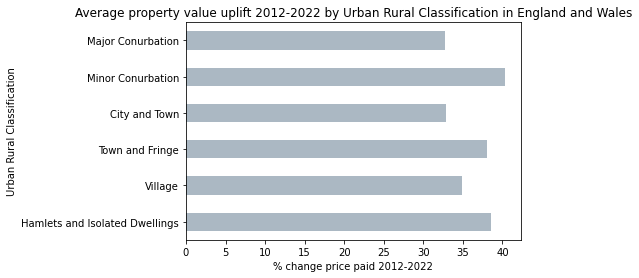

Results can also be grouped by property type:

In [ ]:
geocoded.groupby(['typedesc'])['perchange'].mean().reindex(['Flat/Maisonette', 'Terraced', 'Semi-Detached', 'Detatched']).plot(kind='barh', color = '#f78da7')
plt.xlabel("% change price paid 2012-2022")
plt.ylabel("Property type")
plt.title("Average property value uplift 2012-2022 by property type in England and Wales")

Houses have been, nationally, holding their value more than flats / maisonettes.

Also simply by region:

In [ ]:
geocoded.groupby(['region'])['perchange'].mean().plot(kind='barh', color = '#f78da7')
plt.xlabel("% change price paid 2012-2022")
plt.ylabel("Region by region")
plt.title("Average property value uplift 2012-2022 by region in England and Wales")

There is a general north-south divide, throughout all property types.

Looking in more detail at the heterogeneity, we can plot the individual properties:

The North East and North West growth can be seen again in map form. With the north-south divide there is significant local variation. High value growth is seen in Marget and East London and relatively slower growth was observed in West Central London for example.

In [ ]:
print(geocoded.head(5))

In [ ]:
#BASE MAP

# Define  OS MAPS API Web Map Tile Service
wmts_path = 'https://api.os.uk/maps/raster/v1/wmts?key=cf29UaahD1kovSGU2x3wyFwW09bizUGK'

# OS Maps API (WMTS) endpoint path
wmts_endpoint = 'https://api.os.uk/maps/raster/v1/wmts?'

# Define WMTS parameters 
key = 'cf29UaahD1kovSGU2x3wyFwW09bizUGK'
service = 'wmts'
request = 'GetTile'
version = '2.0.0'
style = 'default'
# Light style base map in Web Mercator projection (EPSG:3857)
layer = 'Light_3857'
tileMatrixSet = 'EPSG:3857'
tileMatrix = 'EPSG:3857:{z}'
tileRow = '{y}'
tileCol ='{x}'

# Represent WMTS parameters in a dictionary
params_wmts = {'key':key, 
              'service':service, 
              'request':request,
              'version':version,
              'style':style,
              'layer':layer,
              'tileMatrixSet':tileMatrixSet,
              'tileMatrix':tileMatrix,
              'tileRow':tileRow,
              'tileCol':tileCol}

# Construct WMTS API path
wmts_path = wmts_endpoint + \
           ('key={key}&'
            'service={service}&'
            'request={request}&'
            'version={version}&'
            'style={style}&'
            'layer={layer}&'
            'tileMatrixSet={tileMatrixSet}&'
            'tileMatrix={tileMatrix}&'
            'tileRow={tileRow}&'
            'tileCol={tileCol}').format(**params_wmts)

print('=> Constructed OS Maps API URL: {}'.format(wmts_path))


# HOUSE PRICE DATA

# create dataframe 
#house_prices = pandas.read_csv('price_paid_2012_2022_epsg4326.csv')# this data is analysed and produced elsewhere


linear = cm.StepColormap(colors=('indigo', 'purple', 'plum', 'lightgreen', 'green', 'black'), #colours relate to the order of below bins
                           vmin=geocoded['perchange'].min(), # tuples of RGBA ints between 0 and 255 (e.g: (255, 255, 0) or colour names e.g. 'yellow'
                           vmax=geocoded['perchange'].max(),
                           index=[-21438, 0,  12, 24, 36, 48] # bins
                           )

m = folium.Map(location=[51.496030, -0.110000], 
               zoom_start=13,
               max_zoom=16,
               tiles=wmts_path, 
               attr='Contains OS Crown Copyright',
               control_scale=True,
               legend_name='percentage change'
               )

for _, row in geocoded.iterrows():
    folium.CircleMarker([row.lat, row.long],
                      popup=['% change:  ', row.perchange],
                      radius=3,
                      color = linear(row.perchange),
                      ).add_to(m)

m.add_child(linear)
display(m)
# export map file
m.save("price_paid_2012_2022.html")

Descriptive statistics can be compared, and for future changes to the input data i.e. different years, calculating record-counts are also wise. These can also be exported as tables for use elsewhere:

In [ ]:
groupby_proptype = geocoded.groupby(['urbrur11'])['perchange'].mean()
groupby_proptype.to_csv('perchange_by_urban_rural_mean.csv')
groupby_urbanrural = geocoded.groupby(['typedesc'])['perchange'].mean()
groupby_urbanrural.to_csv('perchange_by_proptype_mean.csv')
groupby_urbanrural_pt_ = geocoded.groupby(['typedesc', 'urbrur11b'])['perchange'].mean()
groupby_urbanrural_pt_.to_csv('perchange_by_proptype_urban_rural_mean.csv')

groupby_region_proptype = geocoded.groupby(['region', 'typedesc'])['perchange'].mean()
groupby_region_proptype.to_csv('perchange_by_region_proptype_mean.csv')

groupby_region = geocoded.groupby(['region'])['perchange'].mean()
groupby_region.to_csv('perchange_by_region_mean.csv')

groupby_proptypeb = geocoded.groupby(['urbrur11'])['perchange'].count()
groupby_proptypeb.to_csv('perchange_by_urban_rural_counts.csv')
groupby_urbanruralb = geocoded.groupby(['typedesc'])['perchange'].count()
groupby_urbanruralb.to_csv('perchange_by_proptype_counts.csv')
groupby_urbanrural_ptb = geocoded.groupby(['typedesc', 'urbrur11'])['perchange'].count()
groupby_urbanrural_ptb.to_csv('perchange_by_proptype_urban_ruralall_counts.csv')
groupby_urbanrural_ptc = geocoded.groupby(['typedesc', 'urbrur11b'])['perchange'].count()
groupby_urbanrural_ptc.to_csv('perchange_by_proptype_urban_rural_counts.csv')

groupby_region_proptypeb = geocoded.groupby(['region', 'typedesc'])['perchange'].count()
groupby_region_proptypeb.to_csv('perchange_by_region_proptype_counts.csv')

groupby_regionb = geocoded.groupby(['region'])['perchange'].count()
groupby_regionb.to_csv('perchange_by_region_counts.csv')

Some notes on the methodology strengths and weaknesses:

The method tracks individual properties which had a sale recorded in both 2012 then 2022. It's strength is it's weakness in some ways: it reduces some of the big errors that are introduced through using averages against averages in an area over time. It allows you to examine these super-important local-level patterns. But it then becomes sampled data, as the only data points we have are sales that happened to have occurred in those time periods (2012 and 2022). Some counts when segmented by other areas or types then become so small as to be statistically insignificant - i.e. be careful about deducing too much about large areas with one individual sale - there is a lot that can happen to create an uplift in property including renovations which are not controlled for here.

Specifics:

None of the counts 'in a sparse setting' are statistically significant due to low counts, so these have been removed from the groupby queries -type 'other' is also statistically insignificant with 4 properties - I'm not even sure what this category is - land? castles?! It has been removed from results.

The method covers England and Wales only - we cannot assume that the same patterns exist for Scotland or Northern Ireland, having their own distinct housing markets.

The key missing parameter to understand trends in hedonic price modelling is the number of bedrooms and we don't have this, so have to use 'type' as a proxy. It's perhaps not a bad proxy for England and Wales because it often doesn't have the 3-4 bed tenement stock and tenement neighbourhoods that Scotland has.

Because the code is a RAP, data can be plugged in for different time frames and re-run to see what it looks like: 10 years obviously only gives long-term trends, and short term trends may be more pronounced or show different patterns.